# **ISCX 2016:VPN-NON VPN Veriseti Analiz** 

## Kurulumlar

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!apt-get install openjdk-8-jdk-headless -qq 

In [ ]:
!sudo add-apt-repository ppa:webupd8team/java
!sudo apt-get update
!sudo apt-get install oracle-java8-installer

 The Oracle JDK License has changed for releases starting April 16, 2019.

The new Oracle Technology Network License Agreement for Oracle Java SE is substantially different from prior Oracle JDK licenses. The new license permits certain uses, such as personal use and development use, at no cost -- but other uses authorized under prior Oracle JDK licenses may no longer be available. Please review the terms carefully before downloading and using this product. An FAQ is available here: https://www.oracle.com/technetwork/java/javase/overview/oracle-jdk-faqs.html

Oracle Java downloads now require logging in to an Oracle account to download Java updates, like the latest Oracle Java 8u211 / Java SE 8u212. Because of this I cannot update the PPA with the latest Java (and the old links were broken by Oracle).

For this reason, THIS PPA IS DISCONTINUED.

UPDATE:

For Oracle Java 17, see a different PPA -> https://www.linuxuprising.com/2021/09/how-to-install-oracle-java-17-lts-on.html

Old descr

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/ISCX2016_vpn_nonvpn_analiz/

Mounted at /content/drive
/content/drive/My Drive/ISCX2016_vpn_nonvpn_analiz


In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder \
      .master("local") \
      .appName("iscx2016_project") \
      .config("spark.executor.memory", "12gb") \
      .getOrCreate()
    
sc = spark.sparkContext

In [ ]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sbn
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras

## **Veri Tanıma ve Ön İşleme**

1. Ham PCAP dosyalarından CICFlowMeter ile akış özellikleri çıkarıldı ve birleştirildi.

2. Veri setinde kaynak tarafından yapılan güncellemeler mevcut. Sınıflandırma için 142 dosyadan aşağıdaki trafik sınıfları seçildi.  Non-vpn sınıfından SCP ve Vpn- P2P trafiğine ait Bittorrent dahil edilmemiştir.


> **Chat**: AimChat, Facebook, Hangouts, ICQ, Skype

> **Email:** Email

> **VOIP:** Facebook,  Hangouts, Skype, VOIP Buster

> **File Transfer:** FTPS, SFTP, Skype

> **Streaming:** Vimeo, Youtube, Spotify, Netflix

> **VPN-Chat:** AimChat, Facebook, Hangouts, ICQ, Skype

> **VPN-Email:** Email

> **VPN-VOIP:** Facebook,  Hangouts, Skype, VOIP Buster

> **VPN-File Transfer:** FTPS, SFTP, Skype

> **VPN-Streaming:** Vimeo, Youtube, Spotify, Netflix


3. Verisetinde **`Flow ID`, `Src IP`, `Dst IP`,`Timestamp`** sütunları ön işlemede formata dayalı bazı sorunlar oluşturdu. Bu nedenle manuel olarak çıkarılıp dataset_V2.csv dosyası oluşturuldu.

4. Label Encooding yapıldı.

5. Standart sapması 0 olan ve her trafik satırını eşit etkileyen 14 öznitelik belirlendi ve çıkarıldı.

6. Analizde hata verdiği için tüm double sütunlar long olarak değiştirildi.

7. VectorAssembler yapıldı.

8. MinMaxSclar yapıldı.

9. %80 train, %20 test sseti kullanıldı. (Seed değeri:42)



In [ ]:
dataset = pd.read_csv("dataset_V2.csv")

In [ ]:
pd.options.display.float_format = "{:,.2f}".format 

In [ ]:
dataset

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,44917,443,6,119836611,45,45,"3,100.00","6,118.00",234,0,...,0,"3,995,741.40","4,393,032.28","14,100,000.00","201,504.00","7,556,492.70","2,991,503.81","13,600,000.00","5,092,871.00",VPN - Chat
1,48410,443,6,119999002,4,5,24.00,6.00,6,6,...,0,"173,461.75","3,501.47","178,627.00","170,890.00","29,800,000.00","3,109.75","29,800,000.00","29,800,000.00",VPN - Chat
2,34342,443,6,119999037,4,5,24.00,6.00,6,6,...,0,"177,135.00","4,698.99","184,066.00","173,876.00","29,800,000.00","4,218.23","29,800,000.00","29,800,000.00",VPN - Chat
3,44917,443,6,118918424,40,38,"2,978.00","4,816.00",266,0,...,0,"1,911,944.62","2,264,153.35","5,313,599.00",69.00,"12,300,000.00","10,400,000.00","33,000,000.00","5,099,408.00",VPN - Chat
4,48410,443,6,119829597,4,4,24.00,0.00,6,6,...,0,"172,987.33","1,093.70","174,193.00","172,059.00","29,800,000.00","2,395.64","29,800,000.00","29,800,000.00",VPN - Chat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45532,56962,5355,17,418993,1,1,22.00,22.00,22,22,...,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Chat
45533,58618,5355,17,411298,1,1,22.00,22.00,22,22,...,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Chat
45534,50261,5355,17,411211,1,1,22.00,22.00,22,22,...,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Chat
45535,137,137,17,35204260,11,1,550.00,50.00,50,50,...,0,"1,514,065.00",0.00,"1,514,065.00","1,514,065.00","31,400,000.00",0.00,"31,400,000.00","31,400,000.00",Chat


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45537 entries, 0 to 45536
Data columns (total 80 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Src Port           45537 non-null  int64  
 1   Dst Port           45537 non-null  int64  
 2   Protocol           45537 non-null  int64  
 3   Flow Duration      45537 non-null  int64  
 4   Tot Fwd Pkts       45537 non-null  int64  
 5   Tot Bwd Pkts       45537 non-null  int64  
 6   TotLen Fwd Pkts    45537 non-null  float64
 7   TotLen Bwd Pkts    45537 non-null  float64
 8   Fwd Pkt Len Max    45537 non-null  int64  
 9   Fwd Pkt Len Min    45537 non-null  int64  
 10  Fwd Pkt Len Mean   45537 non-null  float64
 11  Fwd Pkt Len Std    45537 non-null  float64
 12  Bwd Pkt Len Max    45537 non-null  int64  
 13  Bwd Pkt Len Min    45537 non-null  int64  
 14  Bwd Pkt Len Mean   45537 non-null  float64
 15  Bwd Pkt Len Std    45537 non-null  float64
 16  Flow Byts/s        455

In [ ]:
dataset.describe()

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,"45,537.00","45,537.00","45,537.00","45,537.00","45,537.00","45,537.00","45,537.00","45,537.00","45,537.00","45,537.00",...,"45,537.00","45,537.00","45,537.00","45,537.00","45,537.00","45,537.00","45,537.00","45,537.00","45,537.00","45,537.00"
mean,"38,298.11","7,580.23",14.22,"15,678,617.65",155.02,188.23,"46,170.80","178,804.62",101.07,13.46,...,75.26,0.00,"306,538.96","185,697.61","549,851.19","166,860.91","5,672,726.28","692,134.38","6,297,555.61","5,076,940.62"
std,"20,599.09","15,007.41",4.93,"35,098,856.68","3,137.06","5,547.91","1,402,335.08","7,311,005.79",844.91,38.09,...,"1,164.60",0.00,"2,464,251.42","1,622,655.75","3,886,524.03","2,017,148.47","15,721,011.07","4,099,770.43","17,013,667.39","15,060,299.80"
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,"19,878.00",53.00,17.00,743.00,0.00,1.00,0.00,22.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,"43,597.00",443.00,17.00,"133,659.00",1.00,2.00,0.00,175.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,"55,672.00","5,355.00",17.00,"421,785.00",1.00,2.00,22.00,378.00,22.00,22.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,"65,534.00","65,514.00",17.00,"119,999,999.00","238,160.00","470,863.00","132,000,000.00","670,000,000.00","64,240.00","1,338.00",...,"62,415.00",0.00,"111,000,000.00","56,600,000.00","111,000,000.00","111,000,000.00","120,000,000.00","76,900,000.00","120,000,000.00","120,000,000.00"


In [ ]:
dataset.Label.value_counts()

VPN - VOIP             13796
VOIP                    7101
Chat                    6596
Email                   5071
VPN - Chat              4540
Streaming               3335
VPN - File Transfer     1794
File Transfer           1598
VPN - Streaming         1137
VPN - Email              569
Name: Label, dtype: int64

Text(0.5, 1.0, 'Numbers of Traffic Classification Labels ')

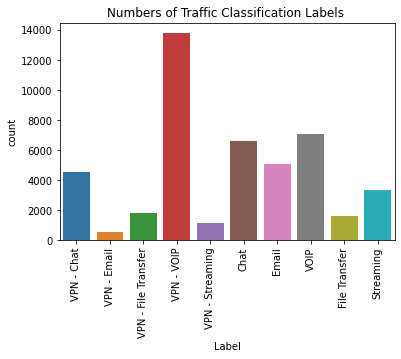

In [ ]:
sbn.countplot(x="Label", data = dataset)
plt.xticks(rotation = 'vertical')
plt.title(label="Numbers of Traffic Classification Labels ")

In [ ]:
from sklearn.preprocessing import LabelEncoder

dataset["Label"]= LabelEncoder().fit_transform(dataset["Label"])

In [ ]:
dataset.Label.value_counts()

9    13796
4     7101
0     6596
1     5071
5     4540
3     3335
7     1794
2     1598
8     1137
6      569
Name: Label, dtype: int64

In [ ]:
data = dataset.iloc[:,:-1]

In [ ]:
zero= []
data.to_numpy()
for i in data:
  if data[i].std(axis=0) == 0:
     zero.append(i)
print(zero)

['Fwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Cnt', 'CWE Flag Count', 'ECE Flag Cnt', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Init Fwd Win Byts', 'Fwd Seg Size Min']


In [ ]:
dataset= dataset.drop(columns= ['Fwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'URG Flag Cnt', 'CWE Flag Count', 
                                'ECE Flag Cnt', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 
                                'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Init Fwd Win Byts', 'Fwd Seg Size Min'])

In [ ]:
dataset = spark.createDataFrame(dataset)

In [ ]:
from pyspark.sql import functions as F

for col in dataset.columns:
  dataset = dataset.withColumn(
    col,
    F.col(col).cast("long")
  )

In [ ]:
dataset.drop("Label").toPandas().columns

Index(['Src Port', 'Dst Port', 'Protocol', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len',
       'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max',
       'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt',
       'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt',
       'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg',
       'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts',
       '

In [ ]:
from pyspark.ml.feature import VectorAssembler

assemblerInput = ["Src Port",	"Dst Port",	"Protocol",'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Bwd PSH Flags', 'Fwd Header Len', 'Bwd Header Len',
       'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max',
       'Pkt Len Mean', 'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt',
       'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt',
       'Down/Up Ratio', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg',
       'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts',
       'Subflow Bwd Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean',
       'Idle Std', 'Idle Max', 'Idle Min']

assembler = VectorAssembler(inputCols= assemblerInput,  outputCol='vectorized_features')

vectorized_dataset = assembler.transform(dataset)

In [ ]:
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(inputCol='vectorized_features', outputCol="scaledFeatures")
scalerModel = scaler.fit(vectorized_dataset)
scaled_Data = scalerModel.transform(vectorized_dataset)

In [ ]:
dataset=scaled_Data.select("scaledFeatures", 'Label')

In [ ]:
dataset.show(2)

+--------------------+-----+
|      scaledFeatures|Label|
+--------------------+-----+
|[0.68539994506668...|    5|
|[0.73870052186651...|    5|
+--------------------+-----+
only showing top 2 rows



In [ ]:
train_data,test_data = dataset.randomSplit([0.8,0.2], seed=42)

## **1 : Random Forest**

In [ ]:
# ----------------RANDOM FOREST ALGORİTMASI------------------

from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='Label', featuresCol='scaledFeatures', maxDepth=30,maxBins=50, seed=42)
model1 = rf.fit(train_data)
prediction1 = model1.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="Label",predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(prediction1)
print("Accuracy = %g" % (accuracy))

evaluator = MulticlassClassificationEvaluator(
    labelCol="Label", predictionCol="prediction", metricName="f1")
F1_Score = evaluator.evaluate(prediction1)
print("F1 Score = %g" % (F1_Score))

evaluator = MulticlassClassificationEvaluator(
    labelCol="Label", predictionCol="prediction", metricName="weightedPrecision")
Precision = evaluator.evaluate(prediction1)
print("Precision = %g" % (Precision))

evaluator = MulticlassClassificationEvaluator(
    labelCol="Label", predictionCol="prediction", metricName="weightedRecall")
Recall = evaluator.evaluate(prediction1)
print("Recall = %g" % (Recall))

Accuracy = 0.80171
F1 Score = 0.796573
Precision = 0.811564
Recall = 0.80171


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true1 = prediction1.select("Label").toPandas()
y_pred1 = prediction1.select("prediction").toPandas()

target_names = ["Chat","Email","File Transfer","Streaming","VOIP","VPN-Chat","VPN-Email","VPN-File Transfer","VPN-Streaming","VPN-VOIP"]
print(classification_report(y_true1, y_pred1, target_names = target_names))

                   precision    recall  f1-score   support

             Chat       0.58      0.76      0.65      1342
            Email       0.72      0.33      0.46       960
    File Transfer       0.93      0.81      0.86       300
        Streaming       0.79      0.83      0.81       641
             VOIP       0.71      0.81      0.76      1428
         VPN-Chat       0.94      0.94      0.94       922
        VPN-Email       0.88      0.89      0.89       109
VPN-File Transfer       0.86      0.86      0.86       376
    VPN-Streaming       0.81      0.84      0.82       232
         VPN-VOIP       0.94      0.91      0.93      2813

         accuracy                           0.80      9123
        macro avg       0.82      0.80      0.80      9123
     weighted avg       0.81      0.80      0.80      9123



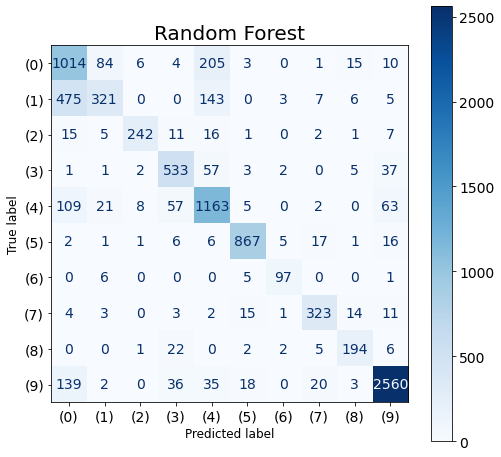

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true1, y_pred1)

target_names =["({})".format(i) for i in range(10)]
cmp = ConfusionMatrixDisplay(cm,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(8,8))
ax.set_title('Random Forest', fontdict = {'fontsize': 20})
ax.set_xlabel("Predicted labels", fontdict = {'fontsize': 12})
ax.set_ylabel('True labels', fontdict = {'fontsize': 12})
plt.rcParams.update({'font.size': 14})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

## **2 : Decision Tree**

In [ ]:
#-----------------DECISION TREE ALGORİTMASI------------------------

from pyspark.ml.classification import DecisionTreeClassifier

dtr = DecisionTreeClassifier(labelCol='Label', featuresCol='scaledFeatures', maxDepth=20,maxBins=50, seed=42)
model2 = dtr.fit(train_data)
predictions2 = model2.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="Label",predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions2)
print("Accuracy = %g" % (accuracy))

evaluator = MulticlassClassificationEvaluator(
    labelCol="Label", predictionCol="prediction", metricName="f1")
F1_Score = evaluator.evaluate(predictions2)
print("F1 Score = %g" % (F1_Score))

evaluator = MulticlassClassificationEvaluator(
    labelCol="Label", predictionCol="prediction", metricName="weightedPrecision")
Precision = evaluator.evaluate(predictions2)
print("Precision = %g" % (Precision))

evaluator = MulticlassClassificationEvaluator(
    labelCol="Label", predictionCol="prediction", metricName="weightedRecall")
Recall = evaluator.evaluate(predictions2)
print("Recall = %g" % (Recall))

Accuracy = 0.780883
F1 Score = 0.782789
Precision = 0.787824
Recall = 0.780883


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true2 = predictions2.select("Label").toPandas()
y_pred2 = predictions2.select("prediction").toPandas()

target_names = ["Chat","Email","File Transfer","Streaming","VOIP","VPN-Chat","VPN-Email","VPN-File Transfer","VPN-Streaming","VPN-VOIP"]
print(classification_report(y_true2, y_pred2, target_names = target_names))

                   precision    recall  f1-score   support

             Chat       0.56      0.69      0.62      1342
            Email       0.55      0.49      0.52       960
    File Transfer       0.91      0.78      0.84       300
        Streaming       0.76      0.79      0.78       641
             VOIP       0.75      0.70      0.73      1428
         VPN-Chat       0.93      0.93      0.93       922
        VPN-Email       0.91      0.88      0.89       109
VPN-File Transfer       0.86      0.81      0.84       376
    VPN-Streaming       0.82      0.85      0.84       232
         VPN-VOIP       0.92      0.90      0.91      2813

         accuracy                           0.78      9123
        macro avg       0.80      0.78      0.79      9123
     weighted avg       0.79      0.78      0.78      9123



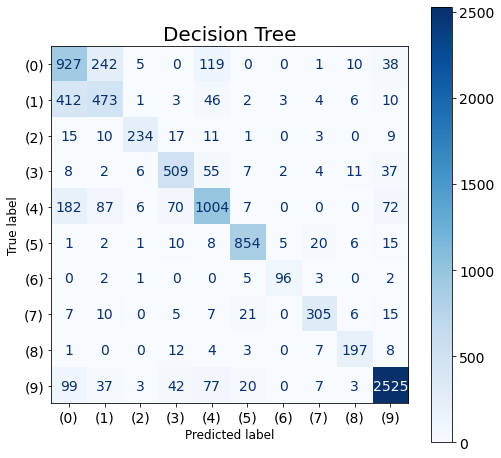

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm2 = confusion_matrix(y_true2, y_pred2)

target_names =["({})".format(i) for i in range(10)]
cmp = ConfusionMatrixDisplay(cm2,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(8,8))
ax.set_title('Decision Tree', fontdict = {'fontsize': 20})
ax.set_xlabel("Predicted labels", fontdict = {'fontsize': 12})
ax.set_ylabel('True labels', fontdict = {'fontsize': 12})
plt.rcParams.update({'font.size': 14})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

## **3 : Naive Bayes**

In [ ]:
#------------------NAIVE BAYES ALGORİTMASI-----------------

from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(labelCol='Label', featuresCol="scaledFeatures", smoothing=1.0, modelType="multinomial")
model3 = nb.fit(train_data)
predictions3 = model3.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="Label",predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions3)
print("Accuracy = %g" % (accuracy))

evaluator = MulticlassClassificationEvaluator(
    labelCol="Label", predictionCol="prediction", metricName="f1")
F1_Score = evaluator.evaluate(predictions3)
print("F1 Score = %g" % (F1_Score))

evaluator = MulticlassClassificationEvaluator(
    labelCol="Label", predictionCol="prediction", metricName="weightedPrecision")
Precision = evaluator.evaluate(predictions3)
print("Precision = %g" % (Precision))

evaluator = MulticlassClassificationEvaluator(
    labelCol="Label", predictionCol="prediction", metricName="weightedRecall")
Recall = evaluator.evaluate(predictions3)
print("Recall = %g" % (Recall))

Accuracy = 0.360956
F1 Score = 0.261633
Precision = 0.366176
Recall = 0.360956


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true3 = predictions3.select("Label").toPandas()
y_pred3 = predictions3.select("prediction").toPandas()

target_names = ["Chat","Email","File Transfer","Streaming","VOIP","VPN-Chat","VPN-Email","VPN-File Transfer","VPN-Streaming","VPN-VOIP"]
print(classification_report(y_true3, y_pred3, target_names = target_names))

                   precision    recall  f1-score   support

             Chat       0.47      0.16      0.24      1342
            Email       0.57      0.08      0.14       960
    File Transfer       0.75      0.20      0.32       300
        Streaming       0.35      0.50      0.42       641
             VOIP       0.33      0.02      0.03      1428
         VPN-Chat       0.06      0.00      0.00       922
        VPN-Email       0.00      0.00      0.00       109
VPN-File Transfer       0.32      0.11      0.17       376
    VPN-Streaming       0.28      0.10      0.15       232
         VPN-VOIP       0.35      0.90      0.51      2813

         accuracy                           0.36      9123
        macro avg       0.35      0.21      0.20      9123
     weighted avg       0.37      0.36      0.26      9123



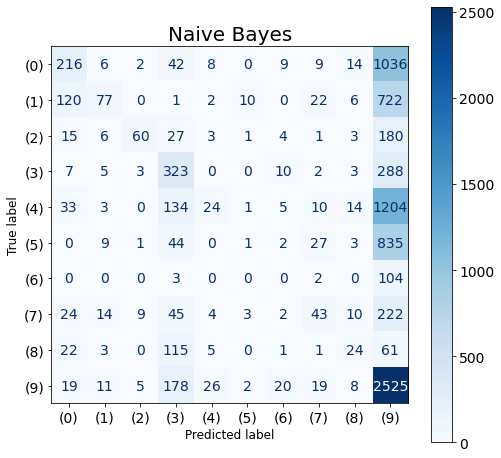

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm3 = confusion_matrix(y_true3, y_pred3)

target_names =["({})".format(i) for i in range(10)]
cmp = ConfusionMatrixDisplay(cm3,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(8,8))
ax.set_title('Naive Bayes', fontdict = {'fontsize': 20})
ax.set_xlabel("Predicted labels", fontdict = {'fontsize': 12})
ax.set_ylabel('True labels', fontdict = {'fontsize': 12})
plt.rcParams.update({'font.size': 14})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

## **4 : Logistic Regression**

In [ ]:
#------------------ LOGISTIC RESGRESSION ALGORİTMASI------------------
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol='Label', featuresCol='scaledFeatures')
model4 = lr.fit(train_data)
predictions4 = model4.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="Label",predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions4)
print("Accuracy = %g" % (accuracy))

evaluator = MulticlassClassificationEvaluator(
    labelCol="Label", predictionCol="prediction", metricName="f1")
F1_Score = evaluator.evaluate(predictions4)
print("F1 Score = %g" % (F1_Score))

evaluator = MulticlassClassificationEvaluator(
    labelCol="Label", predictionCol="prediction", metricName="weightedPrecision")
Precision = evaluator.evaluate(predictions4)
print("Precision = %g" % (Precision))

evaluator = MulticlassClassificationEvaluator(
    labelCol="Label", predictionCol="prediction", metricName="weightedRecall")
Recall = evaluator.evaluate(predictions4)
print("Recall = %g" % (Recall))

Accuracy = 0.580511
F1 Score = 0.540325
Precision = 0.59155
Recall = 0.580511


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true4 = predictions4.select("Label").toPandas()
y_pred4 = predictions4.select("prediction").toPandas()

target_names = ["Chat","Email","File Transfer","Streaming","VOIP","VPN-Chat","VPN-Email","VPN-File Transfer","VPN-Streaming","VPN-VOIP"]
print(classification_report(y_true4, y_pred4, target_names = target_names))

                   precision    recall  f1-score   support

             Chat       0.45      0.81      0.58      1342
            Email       0.55      0.14      0.23       960
    File Transfer       0.65      0.49      0.56       300
        Streaming       0.49      0.57      0.53       641
             VOIP       0.65      0.19      0.30      1428
         VPN-Chat       0.65      0.84      0.73       922
        VPN-Email       0.22      0.15      0.18       109
VPN-File Transfer       0.55      0.28      0.37       376
    VPN-Streaming       0.46      0.31      0.37       232
         VPN-VOIP       0.67      0.82      0.74      2813

         accuracy                           0.58      9123
        macro avg       0.53      0.46      0.46      9123
     weighted avg       0.59      0.58      0.54      9123



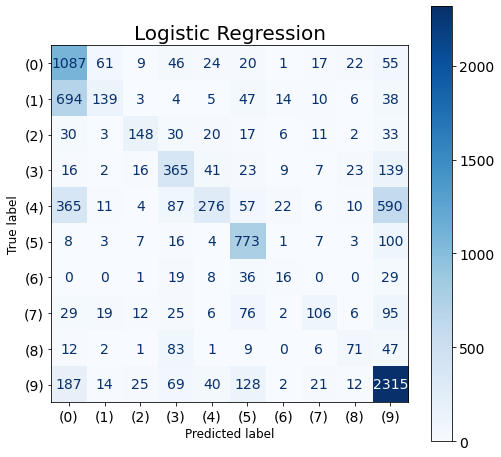

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm4 = confusion_matrix(y_true4, y_pred4)

target_names =["({})".format(i) for i in range(10)]
cmp = ConfusionMatrixDisplay(cm4,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(8,8))
ax.set_title('Logistic Regression', fontdict = {'fontsize': 20})
ax.set_xlabel("Predicted labels", fontdict = {'fontsize': 12})
ax.set_ylabel('True labels', fontdict = {'fontsize': 12})
plt.rcParams.update({'font.size': 14})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

## **5 : MLP**

In [ ]:
#--------------------MULTILAYER PERCEPTRON ALGORİTMASI-------------------

layers = [65,33,10] 

from pyspark.ml.classification import MultilayerPerceptronClassifier

mpc = MultilayerPerceptronClassifier(labelCol='Label', featuresCol="scaledFeatures", 
                        maxIter=100, layers=layers, blockSize=128, seed=42)
model5 = mpc.fit(train_data)
predictions5 = model5.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="Label",predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions5)
print("Accuracy = %g" % (accuracy))

evaluator = MulticlassClassificationEvaluator(
    labelCol="Label", predictionCol="prediction", metricName="f1")
F1_Score = evaluator.evaluate(predictions5)
print("F1 Score = %g" % (F1_Score))

evaluator = MulticlassClassificationEvaluator(
    labelCol="Label", predictionCol="prediction", metricName="weightedPrecision")
Precision = evaluator.evaluate(predictions5)
print("Precision = %g" % (Precision))

evaluator = MulticlassClassificationEvaluator(
    labelCol="Label", predictionCol="prediction", metricName="weightedRecall")
Recall = evaluator.evaluate(predictions5)
print("Recall = %g" % (Recall))

Accuracy = 0.476817
F1 Score = 0.392132
Precision = 0.427671
Recall = 0.476817


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_true5 = predictions5.select("Label").toPandas()
y_pred5 = predictions5.select("prediction").toPandas()

target_names = ["Chat","Email","File Transfer","Streaming","VOIP","VPN-Chat","VPN-Email","VPN-File Transfer","VPN-Streaming","VPN-VOIP"]
print(classification_report(y_true5, y_pred5, target_names = target_names))

                   precision    recall  f1-score   support

             Chat       0.45      0.84      0.58      1342
            Email       0.49      0.14      0.21       960
    File Transfer       0.59      0.52      0.55       300
        Streaming       0.45      0.62      0.52       641
             VOIP       0.28      0.09      0.13      1428
         VPN-Chat       0.25      0.00      0.01       922
        VPN-Email       0.39      0.23      0.29       109
VPN-File Transfer       0.62      0.14      0.23       376
    VPN-Streaming       0.09      0.00      0.01       232
         VPN-VOIP       0.51      0.83      0.63      2813

         accuracy                           0.48      9123
        macro avg       0.41      0.34      0.32      9123
     weighted avg       0.43      0.48      0.39      9123



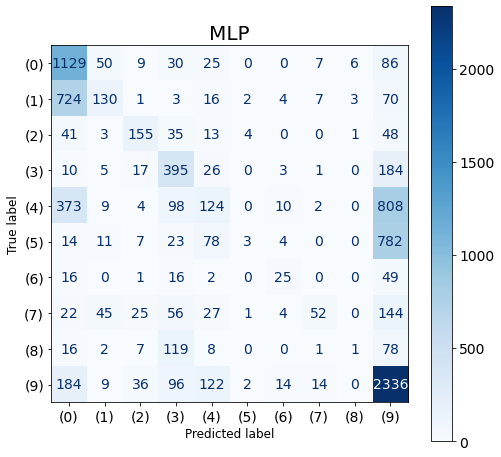

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm5 = confusion_matrix(y_true5, y_pred5)

target_names =["({})".format(i) for i in range(10)]
cmp = ConfusionMatrixDisplay(cm5,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(8,8))
ax.set_title('MLP', fontdict = {'fontsize': 20})
ax.set_xlabel("Predicted labels", fontdict = {'fontsize': 12})
ax.set_ylabel('True labels', fontdict = {'fontsize': 12})
plt.rcParams.update({'font.size': 14})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

## **6 : DNN**

In [ ]:
xtrain_array = np.asarray(train_data.select('scaledFeatures').collect())
xtest_array = np.asarray(test_data.select('scaledFeatures').collect())
ytrain_array = np.asarray(train_data.select('Label').collect())
ytest_array = np.asarray(test_data.select('Label').collect())

In [ ]:
import tensorflow.keras.utils as u
ytrain_OHE = u.to_categorical(ytrain_array)
ytest_OHE = u.to_categorical(ytest_array)

In [ ]:
print(ytrain_OHE.shape)
print(ytest_OHE.shape)
print(xtrain_array.shape)
print(xtest_array.shape)

(36414, 10)
(9123, 10)
(36414, 1, 65)
(9123, 1, 65)


In [ ]:
xtrain_array =xtrain_array.reshape(-1,65)
xtest_array = xtest_array.reshape(-1,65)

In [ ]:
print(ytrain_OHE.shape)
print(ytest_OHE.shape)
print(xtrain_array.shape)
print(xtest_array.shape)

(36414, 10)
(9123, 10)
(36414, 65)
(9123, 65)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import models,layers
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model6 = Sequential()

model6.add(Dense(128,activation = "relu"))

model6.add(Dense(64,activation = "relu"))

model6.add(Dense(64,activation = "relu"))

model6.add(Dense(10,activation = "softmax"))

model6.compile(loss="categorical_crossentropy",optimizer = "adam")

earlyStopping = EarlyStopping(monitor="val_loss",mode="min",verbose=1,patience=25) 

model6.fit(xtrain_array, ytrain_OHE, epochs=30, 
          validation_data=(xtest_array, ytest_OHE),verbose=1, callbacks=[earlyStopping])

Epoch 1/30
1138/1138 [==============================] - 3s 2ms/step - loss: 1.5135 - val_loss: 1.3575
Epoch 2/30
1138/1138 [==============================] - 2s 2ms/step - loss: 1.3158 - val_loss: 1.2703
Epoch 3/30
1138/1138 [==============================] - 2s 2ms/step - loss: 1.2544 - val_loss: 1.2328
Epoch 4/30
1138/1138 [==============================] - 2s 2ms/step - loss: 1.2052 - val_loss: 1.1513
Epoch 5/30
1138/1138 [==============================] - 2s 2ms/step - loss: 1.1101 - val_loss: 1.0505
Epoch 6/30
1138/1138 [==============================] - 2s 2ms/step - loss: 1.0360 - val_loss: 1.0719
Epoch 7/30
1138/1138 [==============================] - 3s 2ms/step - loss: 1.0024 - val_loss: 0.9822
Epoch 8/30
1138/1138 [==============================] - 3s 2ms/step - loss: 0.9757 - val_loss: 0.9647
Epoch 9/30
1138/1138 [==============================] - 2s 2ms/step - loss: 0.9503 - val_loss: 0.9380
Epoch 10/30
1138/1138 [==============================] - 2s 2ms/step - loss: 0.928

In [ ]:
model6.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 128)               8448      
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 64)                4160      
                                                                 
 dense_20 (Dense)            (None, 10)                650       
                                                                 
Total params: 21,514
Trainable params: 21,514
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Deep Neural Network (DNN)')

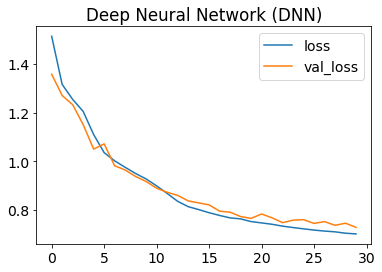

In [ ]:
kayipDf6 = pd.DataFrame(model6.history.history)
ax6 = kayipDf6.plot()
ax6.set_title("Deep Neural Network (DNN)")

In [ ]:
y_pred6 = model6.predict(xtest_array)
y_pred6=np.argmax(y_pred6, axis=1)
ytest_OHE =np.argmax(ytest_OHE, axis=1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ["Chat","Email","File Transfer","Streaming","VOIP","VPN-Chat","VPN-Email","VPN-File Transfer","VPN-Streaming","VPN-VOIP"]
print(classification_report(ytest_OHE,y_pred6, target_names=target_names))

                   precision    recall  f1-score   support

             Chat       0.49      0.93      0.65      1342
            Email       0.84      0.16      0.27       960
    File Transfer       0.89      0.70      0.78       300
        Streaming       0.64      0.63      0.64       641
             VOIP       0.79      0.57      0.66      1428
         VPN-Chat       0.84      0.88      0.86       922
        VPN-Email       0.59      0.61      0.60       109
VPN-File Transfer       0.74      0.73      0.73       376
    VPN-Streaming       0.64      0.59      0.61       232
         VPN-VOIP       0.87      0.88      0.88      2813

         accuracy                           0.72      9123
        macro avg       0.73      0.67      0.67      9123
     weighted avg       0.77      0.72      0.71      9123



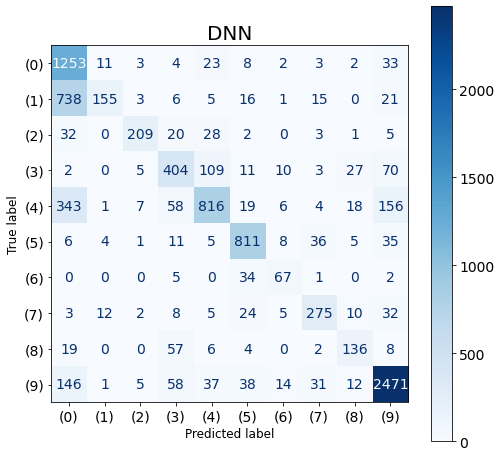

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm6 = confusion_matrix(ytest_array,y_pred6)

target_names =["({})".format(i) for i in range(10)]
cmp = ConfusionMatrixDisplay(cm6,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(8,8))
ax.set_title('DNN', fontdict = {'fontsize': 20})
ax.set_xlabel("Predicted labels", fontdict = {'fontsize': 12})
ax.set_ylabel('True labels', fontdict = {'fontsize': 12})
plt.rcParams.update({'font.size': 14})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score
print ("accuracy: ",accuracy_score(ytest_array, y_pred6))
print ("f1-score: ",f1_score(ytest_array, y_pred6, average="weighted"))
print ("recall: ", recall_score(ytest_array, y_pred6,average="weighted"))
print ("precision: ", precision_score(ytest_array, y_pred6, average="weighted"))

accuracy:  0.7231173955935547
f1-score:  0.7072713684320984
recall:  0.7231173955935547
precision:  0.7664723300198157


## **7 : LSTM**

In [ ]:
xtrain_array = np.asarray(train_data.select('scaledFeatures').collect())
xtest_array = np.asarray(test_data.select('scaledFeatures').collect())
ytrain_array = np.asarray(train_data.select('Label').collect())
ytest_array = np.asarray(test_data.select('Label').collect())

In [ ]:
import tensorflow.keras.utils as u
ytrain_OHE = u.to_categorical(ytrain_array)
ytest_OHE = u.to_categorical(ytest_array)

In [ ]:
print(ytrain_OHE.shape)
print(ytest_OHE.shape)
print(xtrain_array.shape)
print(xtest_array.shape)

(36414, 10)
(9123, 10)
(36414, 1, 65)
(9123, 1, 65)


In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model7 = Sequential()

model7.add(layers.LSTM(64, activation = "relu", return_sequences = True))

model7.add(layers.LSTM(64, activation = "relu", return_sequences = False))

model7.add(Dense(10,activation = "softmax"))

model7.compile(loss="categorical_crossentropy",optimizer = "adam")

earlyStopping = EarlyStopping(monitor="val_loss",mode="min",verbose=1,patience=25)

model7.fit(xtrain_array, ytrain_OHE, epochs=30, 
          validation_data=(xtest_array, ytest_OHE),verbose=1, callbacks=[earlyStopping])

Epoch 1/30
1138/1138 [==============================] - 12s 8ms/step - loss: 1.6971 - val_loss: 1.4598
Epoch 2/30
1138/1138 [==============================] - 5s 4ms/step - loss: 1.4376 - val_loss: 1.3821
Epoch 3/30
1138/1138 [==============================] - 5s 4ms/step - loss: 1.3778 - val_loss: 1.3411
Epoch 4/30
1138/1138 [==============================] - 4s 4ms/step - loss: 1.3344 - val_loss: 1.2996
Epoch 5/30
1138/1138 [==============================] - 4s 4ms/step - loss: 1.2995 - val_loss: 1.2688
Epoch 6/30
1138/1138 [==============================] - 5s 4ms/step - loss: 1.2726 - val_loss: 1.2553
Epoch 7/30
1138/1138 [==============================] - 4s 4ms/step - loss: 1.2499 - val_loss: 1.2335
Epoch 8/30
1138/1138 [==============================] - 4s 4ms/step - loss: 1.2270 - val_loss: 1.2070
Epoch 9/30
1138/1138 [==============================] - 5s 4ms/step - loss: 1.2006 - val_loss: 1.1767
Epoch 10/30
1138/1138 [==============================] - 5s 4ms/step - loss: 1.16

In [ ]:
model7.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 1, 64)             33280     
                                                                 
 lstm_13 (LSTM)              (None, 64)                33024     
                                                                 
 dense_21 (Dense)            (None, 10)                650       
                                                                 
Total params: 66,954
Trainable params: 66,954
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Long Short-Term Memory (LSTM)')

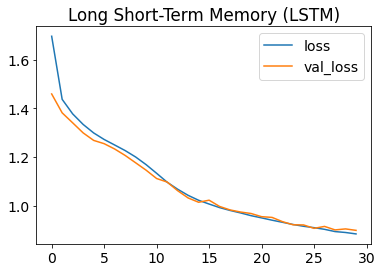

In [ ]:
kayipDf7 = pd.DataFrame(model7.history.history)
ax7 = kayipDf7.plot()
ax7.set_title("Long Short-Term Memory (LSTM)")

In [ ]:
y_pred7 = model7.predict(xtest_array)
y_pred7=np.argmax(y_pred7, axis=1)
ytest_OHE =np.argmax(ytest_OHE, axis=1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ["Chat","Email","File Transfer","Streaming","VOIP","VPN-Chat","VPN-Email","VPN-File Transfer","VPN-Streaming","VPN-VOIP"]
print(classification_report(ytest_OHE,y_pred7, target_names=target_names))

                   precision    recall  f1-score   support

             Chat       0.48      0.92      0.63      1342
            Email       0.75      0.14      0.24       960
    File Transfer       0.84      0.66      0.74       300
        Streaming       0.60      0.63      0.61       641
             VOIP       0.70      0.54      0.61      1428
         VPN-Chat       0.78      0.90      0.83       922
        VPN-Email       0.53      0.60      0.56       109
VPN-File Transfer       0.66      0.67      0.66       376
    VPN-Streaming       0.64      0.48      0.55       232
         VPN-VOIP       0.86      0.81      0.84      2813

         accuracy                           0.69      9123
        macro avg       0.68      0.63      0.63      9123
     weighted avg       0.72      0.69      0.67      9123



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score
print ("accuracy: ",accuracy_score(ytest_array, y_pred7))
print ("f1-score: ",f1_score(ytest_array, y_pred7, average="weighted"))
print ("recall: ", recall_score(ytest_array, y_pred7,average="weighted"))
print ("precision: ", precision_score(ytest_array, y_pred7, average="weighted"))

accuracy:  0.6866162446563631
f1-score:  0.6702382735649971
recall:  0.6866162446563631
precision:  0.7235382168372511


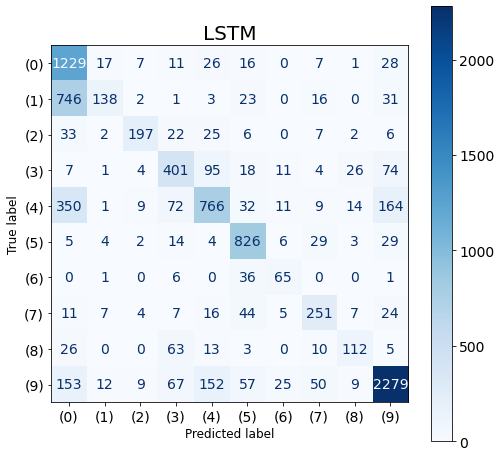

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm7 = confusion_matrix(ytest_array,y_pred7)

target_names =["({})".format(i) for i in range(10)]
cmp = ConfusionMatrixDisplay(cm7,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(8,8))
ax.set_title('LSTM', fontdict = {'fontsize': 20})
ax.set_xlabel("Predicted labels", fontdict = {'fontsize': 12})
ax.set_ylabel('True labels', fontdict = {'fontsize': 12})
plt.rcParams.update({'font.size': 14})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

## **8 : CNN - 1D**

In [ ]:
xtrain_array = np.asarray(train_data.select('scaledFeatures').collect())
xtest_array = np.asarray(test_data.select('scaledFeatures').collect())
ytrain_array = np.asarray(train_data.select('Label').collect())
ytest_array = np.asarray(test_data.select('Label').collect())

In [ ]:
import tensorflow.keras.utils as u
ytrain_OHE = u.to_categorical(ytrain_array)
ytest_OHE = u.to_categorical(ytest_array)

In [ ]:
print(ytrain_OHE.shape)
print(ytest_OHE.shape)
print(xtrain_array.shape)
print(xtest_array.shape)

(36414, 10)
(9123, 10)
(36414, 1, 65)
(9123, 1, 65)


In [ ]:
xtrain_array =xtrain_array.reshape(-1,13,5)
xtest_array = xtest_array.reshape(-1,13,5)

In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
from sklearn import metrics
model8 = Sequential()
model8.add(layers.Conv1D(64, 2, activation="relu", input_shape=(13,5)))
model8.add(layers.MaxPooling1D(2))
model8.add(layers.Conv1D(64, 2, activation="relu"))
model8.add(layers.MaxPooling1D(2))
model8.add(layers.Conv1D(128,2, activation="relu"))
model8.add(layers.Flatten())
model8.add(Dense(128, activation="relu"))
model8.add(Dense(10, activation = 'softmax'))
model8.compile(loss = 'categorical_crossentropy', optimizer = "adam" )


model8.fit(xtrain_array, ytrain_OHE, epochs=30,verbose=1, validation_data=(xtest_array, ytest_OHE))


Epoch 1/30
1138/1138 [==============================] - 5s 4ms/step - loss: 1.5519 - val_loss: 1.3752
Epoch 2/30
1138/1138 [==============================] - 5s 4ms/step - loss: 1.3363 - val_loss: 1.2731
Epoch 3/30
1138/1138 [==============================] - 4s 4ms/step - loss: 1.2418 - val_loss: 1.2234
Epoch 4/30
1138/1138 [==============================] - 5s 4ms/step - loss: 1.1061 - val_loss: 1.0542
Epoch 5/30
1138/1138 [==============================] - 4s 4ms/step - loss: 1.0282 - val_loss: 0.9824
Epoch 6/30
1138/1138 [==============================] - 4s 4ms/step - loss: 0.9544 - val_loss: 0.9117
Epoch 7/30
1138/1138 [==============================] - 5s 4ms/step - loss: 0.9034 - val_loss: 0.8967
Epoch 8/30
1138/1138 [==============================] - 4s 4ms/step - loss: 0.8740 - val_loss: 0.8594
Epoch 9/30
1138/1138 [==============================] - 4s 4ms/step - loss: 0.8561 - val_loss: 0.8369
Epoch 10/30
1138/1138 [==============================] - 5s 4ms/step - loss: 0.837

In [ ]:
model8.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 12, 64)            704       
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 6, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_12 (Conv1D)          (None, 5, 64)             8256      
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 2, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 1, 128)            16512     
                                                                 
 flatten_5 (Flatten)         (None, 128)             

Text(0.5, 1.0, 'Convolutional Neural Network (CNN-1D)')

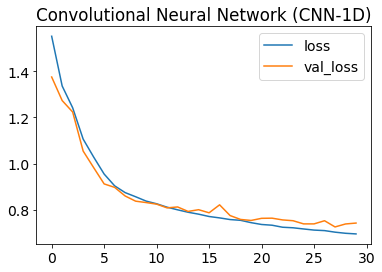

In [ ]:
kayipDf8 = pd.DataFrame(model8.history.history)
ax8 = kayipDf8.plot()
ax8.set_title("Convolutional Neural Network (CNN-1D)")

In [ ]:
y_pred8 = model8.predict(xtest_array)
y_pred8=np.argmax(y_pred8, axis=1)
ytest_OHE =np.argmax(ytest_OHE, axis=1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ["Chat","Email","File Transfer","Streaming","VOIP","VPN-Chat","VPN-Email","VPN-File Transfer","VPN-Streaming","VPN-VOIP"]
print(classification_report(ytest_OHE,y_pred8, target_names=target_names))

                   precision    recall  f1-score   support

             Chat       0.49      0.93      0.65      1342
            Email       0.60      0.16      0.25       960
    File Transfer       0.85      0.69      0.76       300
        Streaming       0.66      0.63      0.64       641
             VOIP       0.77      0.57      0.66      1428
         VPN-Chat       0.86      0.85      0.86       922
        VPN-Email       0.71      0.61      0.66       109
VPN-File Transfer       0.64      0.73      0.68       376
    VPN-Streaming       0.59      0.56      0.57       232
         VPN-VOIP       0.88      0.86      0.87      2813

         accuracy                           0.71      9123
        macro avg       0.71      0.66      0.66      9123
     weighted avg       0.74      0.71      0.70      9123



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score
print ("accuracy: ",accuracy_score(ytest_array, y_pred8))
print ("f1-score: ",f1_score(ytest_array, y_pred8, average="weighted"))
print ("recall: ", recall_score(ytest_array, y_pred8,average="weighted"))
print ("precision: ", precision_score(ytest_array, y_pred8, average="weighted"))

accuracy:  0.7146771895209909
f1-score:  0.7004475184251836
recall:  0.7146771895209909
precision:  0.7382039612272242


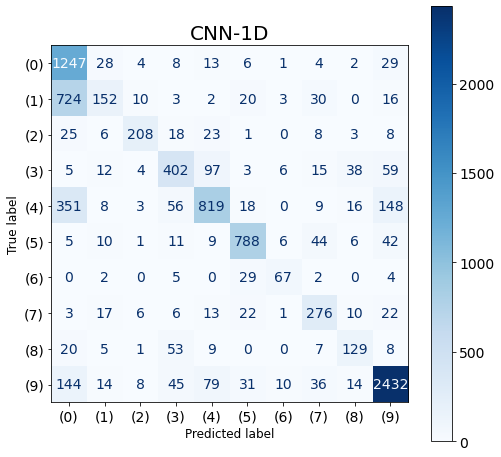

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm8 = confusion_matrix(ytest_array,y_pred8)

target_names =["({})".format(i) for i in range(10)]
cmp = ConfusionMatrixDisplay(cm8,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(8,8))
ax.set_title('CNN-1D', fontdict = {'fontsize': 20})
ax.set_xlabel("Predicted labels", fontdict = {'fontsize': 12})
ax.set_ylabel('True labels', fontdict = {'fontsize': 12})
plt.rcParams.update({'font.size': 14})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

## **9 : GRU**

In [ ]:
xtrain_array = np.asarray(train_data.select('scaledFeatures').collect())
xtest_array = np.asarray(test_data.select('scaledFeatures').collect())
ytrain_array = np.asarray(train_data.select('Label').collect())
ytest_array = np.asarray(test_data.select('Label').collect())

In [ ]:
import tensorflow.keras.utils as u
ytrain_OHE = u.to_categorical(ytrain_array)
ytest_OHE = u.to_categorical(ytest_array)

In [ ]:
print(ytrain_OHE.shape)
print(ytest_OHE.shape)
print(xtrain_array.shape)
print(xtest_array.shape)

(36414, 10)
(9123, 10)
(36414, 1, 65)
(9123, 1, 65)


In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model9 = Sequential()

model9.add(layers.GRU(40, activation = "relu", return_sequences = True))

model9.add(layers.GRU(16, activation = "relu", return_sequences = False))

model9.add(Dense(10,activation = "softmax"))

model9.compile(loss="categorical_crossentropy",optimizer = "adam")

earlyStopping = EarlyStopping(monitor="val_loss",mode="min",verbose=1,patience=25)

model9.fit(xtrain_array, ytrain_OHE, epochs=30, 
          validation_data=(xtest_array, ytest_OHE),verbose=1, callbacks=[earlyStopping])

Epoch 1/30
1138/1138 [==============================] - 7s 4ms/step - loss: 1.7066 - val_loss: 1.4750
Epoch 2/30
1138/1138 [==============================] - 4s 4ms/step - loss: 1.4470 - val_loss: 1.3939
Epoch 3/30
1138/1138 [==============================] - 4s 3ms/step - loss: 1.3905 - val_loss: 1.3531
Epoch 4/30
1138/1138 [==============================] - 4s 4ms/step - loss: 1.3517 - val_loss: 1.3192
Epoch 5/30
1138/1138 [==============================] - 4s 4ms/step - loss: 1.3243 - val_loss: 1.2949
Epoch 6/30
1138/1138 [==============================] - 4s 4ms/step - loss: 1.3019 - val_loss: 1.2824
Epoch 7/30
1138/1138 [==============================] - 4s 4ms/step - loss: 1.2834 - val_loss: 1.2615
Epoch 8/30
1138/1138 [==============================] - 4s 4ms/step - loss: 1.2624 - val_loss: 1.2412
Epoch 9/30
1138/1138 [==============================] - 4s 4ms/step - loss: 1.2385 - val_loss: 1.2116
Epoch 10/30
1138/1138 [==============================] - 4s 3ms/step - loss: 1.212

In [ ]:
model9.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 1, 40)             12840     
                                                                 
 gru_3 (GRU)                 (None, 16)                2784      
                                                                 
 dense_24 (Dense)            (None, 10)                170       
                                                                 
Total params: 15,794
Trainable params: 15,794
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Gated Recurrent Units (GRU)')

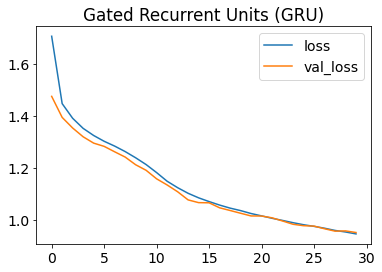

In [ ]:
kayipDf9 = pd.DataFrame(model9.history.history)
ax9 = kayipDf9.plot()
ax9.set_title("Gated Recurrent Units (GRU)")

In [ ]:
y_pred9 = model9.predict(xtest_array)
y_pred9=np.argmax(y_pred9, axis=1)
ytest_OHE =np.argmax(ytest_OHE, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score
print ("accuracy: ",accuracy_score(ytest_array, y_pred9))
print ("f1-score: ",f1_score(ytest_array, y_pred9, average="weighted"))
print ("recall: ", recall_score(ytest_array, y_pred9,average="weighted"))
print ("precision: ", precision_score(ytest_array, y_pred9, average="weighted"))

accuracy:  0.6688589279842158
f1-score:  0.6514346205976626
recall:  0.6688589279842158
precision:  0.7003485159703317


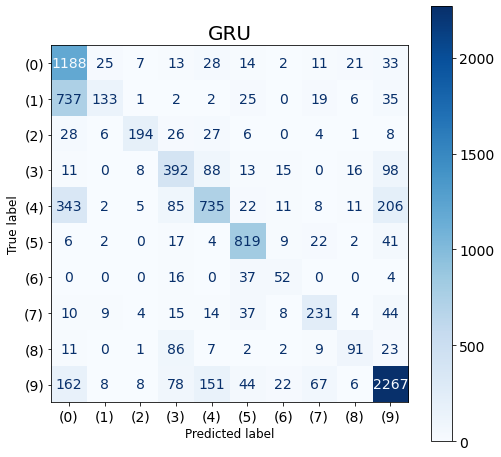

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm9 = confusion_matrix(ytest_array,y_pred9)

target_names =["({})".format(i) for i in range(10)]
cmp = ConfusionMatrixDisplay(cm9,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(8,8))
ax.set_title('GRU', fontdict = {'fontsize': 20})
ax.set_xlabel("Predicted labels", fontdict = {'fontsize': 12})
ax.set_ylabel('True labels', fontdict = {'fontsize': 12})
plt.rcParams.update({'font.size': 14})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

## 10: CNN-LSTM

In [ ]:
xtrain_array = np.asarray(train_data.select('scaledFeatures').collect())
xtest_array = np.asarray(test_data.select('scaledFeatures').collect())
ytrain_array = np.asarray(train_data.select('Label').collect())
ytest_array = np.asarray(test_data.select('Label').collect())

In [ ]:
import tensorflow.keras.utils as u
ytrain_OHE = u.to_categorical(ytrain_array)
ytest_OHE = u.to_categorical(ytest_array)

In [ ]:
print(ytrain_OHE.shape)
print(ytest_OHE.shape)
print(xtrain_array.shape)
print(xtest_array.shape)

(36414, 10)
(9123, 10)
(36414, 1, 65)
(9123, 1, 65)


In [ ]:
xtrain_array =xtrain_array.reshape(-1,13,5)
xtest_array = xtest_array.reshape(-1,13,5)

In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import models,layers
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import os
os.environ['PYTHONHASHSEED']=str(42)
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model10 = Sequential()
model10.add(layers.Conv1D(128, 2,activation="relu", input_shape=(13,5)))
model10.add(layers.MaxPooling1D(2))
model10.add(layers.Conv1D(64, 2, activation="relu"))
model10.add(layers.MaxPooling1D(2))
model10.add(layers.LSTM(128, activation = "relu", return_sequences = True))
model10.add(layers.LSTM(64, activation = "relu", return_sequences = False))
model10.add(layers.Flatten())
model10.add(Dense(128, activation="relu"))
model10.add(Dense(10, activation = 'softmax'))
model10.compile(loss = 'categorical_crossentropy', optimizer = "adam" )
earlyStopping = EarlyStopping(monitor="val_loss",mode="min",verbose=1,patience=25)

model10.fit(xtrain_array, ytrain_OHE, epochs=30, 
          validation_data=(xtest_array, ytest_OHE),verbose=1, callbacks=[earlyStopping])

Epoch 1/30
1138/1138 [==============================] - 13s 10ms/step - loss: 1.6582 - val_loss: 1.4695
Epoch 2/30
1138/1138 [==============================] - 10s 9ms/step - loss: 1.4376 - val_loss: 1.3582
Epoch 3/30
1138/1138 [==============================] - 11s 9ms/step - loss: 1.3440 - val_loss: 1.3073
Epoch 4/30
1138/1138 [==============================] - 10s 9ms/step - loss: 1.2672 - val_loss: 1.1837
Epoch 5/30
1138/1138 [==============================] - 11s 9ms/step - loss: 1.1464 - val_loss: 1.1171
Epoch 6/30
1138/1138 [==============================] - 11s 10ms/step - loss: 1.0844 - val_loss: 1.0510
Epoch 7/30
1138/1138 [==============================] - 11s 9ms/step - loss: 1.0446 - val_loss: 0.9700
Epoch 8/30
1138/1138 [==============================] - 11s 9ms/step - loss: 0.9854 - val_loss: 1.0207
Epoch 9/30
1138/1138 [==============================] - 11s 10ms/step - loss: 0.9258 - val_loss: 0.9133
Epoch 10/30
1138/1138 [==============================] - 11s 10ms/step

In [ ]:
model10.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 12, 128)           1408      
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 6, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_15 (Conv1D)          (None, 5, 64)             16448     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 2, 64)            0         
 g1D)                                                            
                                                                 
 lstm_14 (LSTM)              (None, 2, 128)            98816     
                                                                 
 lstm_15 (LSTM)              (None, 64)              

Text(0.5, 1.0, 'CNN-LSTM')

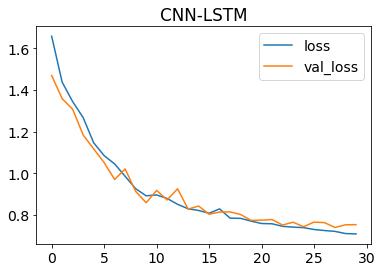

In [ ]:
kayipDf10 = pd.DataFrame(model10.history.history)
ax10 = kayipDf10.plot()
ax10.set_title("CNN-LSTM")

In [ ]:
y_pred10 = model10.predict(xtest_array)
y_pred10=np.argmax(y_pred10, axis=1)
ytest_OHE =np.argmax(ytest_OHE, axis=1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ["Chat","Email","File Transfer","Streaming","VOIP","VPN-Chat","VPN-Email","VPN-File Transfer","VPN-Streaming","VPN-VOIP"]
print(classification_report(ytest_OHE,y_pred10, target_names=target_names))

                   precision    recall  f1-score   support

             Chat       0.49      0.93      0.64      1342
            Email       0.52      0.16      0.24       960
    File Transfer       0.92      0.70      0.80       300
        Streaming       0.61      0.63      0.62       641
             VOIP       0.80      0.56      0.66      1428
         VPN-Chat       0.82      0.87      0.84       922
        VPN-Email       0.62      0.60      0.61       109
VPN-File Transfer       0.74      0.71      0.73       376
    VPN-Streaming       0.64      0.52      0.58       232
         VPN-VOIP       0.88      0.86      0.87      2813

         accuracy                           0.71      9123
        macro avg       0.70      0.65      0.66      9123
     weighted avg       0.73      0.71      0.70      9123



In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score
print ("accuracy: ",accuracy_score(ytest_array, y_pred10))
print ("f1-score: ",f1_score(ytest_array, y_pred10, average="weighted"))
print ("recall: ", recall_score(ytest_array, y_pred10,average="weighted"))
print ("precision: ", precision_score(ytest_array, y_pred10, average="weighted"))

accuracy:  0.7116080236764222
f1-score:  0.6976588360416588
recall:  0.7116080236764222
precision:  0.7313944959598825


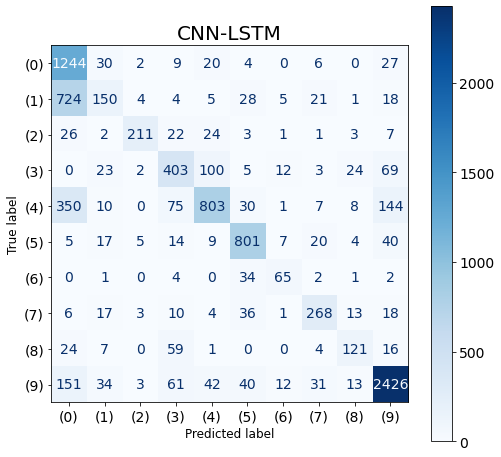

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

cm10 = confusion_matrix(ytest_array,y_pred10)

target_names =["({})".format(i) for i in range(10)]
cmp = ConfusionMatrixDisplay(cm10,display_labels=target_names)
fig, ax, = plt.subplots(figsize=(8,8))
ax.set_title('CNN-LSTM', fontdict = {'fontsize': 20})
ax.set_xlabel("Predicted labels", fontdict = {'fontsize': 12})
ax.set_ylabel('True labels', fontdict = {'fontsize': 12})
plt.rcParams.update({'font.size': 14})
cmp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()